In [1]:
import numpy as np, pandas as pd
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime, date, time, timedelta
import utils


In [2]:
input_dir = "../data/"
output_dir = "../data/processed_orig_data/"


# Preprocess Air Quality Data

Need to convert the data to have a single time column. Original data has Date and Time in separate columns.

In [10]:
air = pd.read_csv(f"{input_dir}AirQualityUCI.csv")
air.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [11]:
def parse_time_from_string(time_string,  format = '%H:%M:%S'):
    return datetime.strptime(time_string, format).time()

def parse_date_from_string(date_string, format='%m/%d/%Y'):
    return datetime.strptime(date_string, format)     # '%Y-%m-%d'

In [12]:
air['Date'] = air['Date'].apply(parse_date_from_string)
air['Time'] = air['Time'].apply(parse_time_from_string)

air['DateTime'] = air.apply(lambda row: datetime.combine(row['Date'], row['Time']), axis=1 )

air.drop(columns = ['Date', 'Time'], inplace=True)
air.head()

air.to_csv(f"{input_dir}/AirQualityUCI_processed.csv", index=False)

# Stocks, Air and Energy Data

In [3]:
data_dict = {
    'energy': {
        'file': 'Energy-energydata_complete.csv',
        'time_col': 'date',
    },
    'stocks': {
        'file': 'stock_data.csv',
        'time_col': None, 
    },
    'stocks2': {
        'file': 'stocks_verint.csv',
        'time_col': None, 
    },
    'air': {
        'file': 'AirQualityUCI_processed.csv',
        'time_col': 'DateTime',
    },
}

### Choose Data

In [4]:
# selected = 'energy'
# selected = 'stocks'
selected = 'stocks2'
# selected = 'air'

In [5]:
file_path = os.path.join(input_dir, data_dict[selected]['file'])

if data_dict[selected]['time_col'] is not None: 
    data = pd.read_csv(file_path, parse_dates=[data_dict[selected]['time_col']])
else:
    data = pd.read_csv(file_path)
print(data.head())

        Open       High        Low      Close  Adj Close   Volume
0  17.427406  17.539480  16.826286  16.958736  16.958736  1315210
1  17.024961  17.784004  16.989302  17.437595  17.437595   935762
2  17.340805  17.473255  17.198166  17.289862  17.289862  1167396
3  17.233826  17.371370  16.897606  17.269485  17.269485   671150
4  17.137035  17.289862  16.729496  16.917982  16.917982   915347


In [6]:
print("data shape: ", data.shape)

data shape:  (3943, 6)


### Sort data by time

In [7]:
time_col = data_dict[selected]['time_col']
print(time_col)

None


In [8]:
if time_col in data: 
    data.sort_values(by=time_col, inplace=True)
    data.reset_index(drop=True, inplace=True)

### Delete the time col

In [9]:
if time_col in data: del data[time_col]
print("data shape: ", data.shape)

data shape:  (3943, 6)


### Train Test Split

In [12]:
N = data.shape[0]
TEST_PERC = 0.00
TRAIN_PERC = 1- TEST_PERC

perc_of_train_data = [2, 5, 10, 20, 100]

frac_datasets = []
for p in perc_of_train_data: 
    
    num_test = int(N * TEST_PERC)   # to be held-out
    orig_num_train = N - num_test
    
    test_data = data.tail(num_test)  # to be used for evaluation later
    
    orig_train_data = data.loc[np.arange(orig_num_train)]
    #print(orig_train_data.shape)
    
    num_train_frac = int(orig_num_train * p / 100.)
    #print(f'Num train steps for p = {p} is {num_train_frac}')
    
    train_data_frac = data.tail(num_train_frac) 
    frac_datasets.append(train_data_frac)
    print(f'frac:{p}%, train_data_frac shape: {train_data_frac.shape}' )
    
    #np.save(os.path.join(data_dir, f'{selected}_train_perc_{p}.npy'), train_data_frac)

frac:2%, train_data_frac shape: (78, 6)
frac:5%, train_data_frac shape: (197, 6)
frac:10%, train_data_frac shape: (394, 6)
frac:20%, train_data_frac shape: (788, 6)
frac:100%, train_data_frac shape: (3943, 6)


### Convert to 3D tensors
shape = N, T, D 

In [13]:
for i, d in enumerate(frac_datasets):
    frac_datasets[i] = d.values.reshape(1, *d.shape)
    print("reshaped: ", frac_datasets[i].shape)

reshaped:  (1, 78, 6)
reshaped:  (1, 197, 6)
reshaped:  (1, 394, 6)
reshaped:  (1, 788, 6)
reshaped:  (1, 3943, 6)


### Create Subsampled series of required seq_len

In [15]:

T = 24
for p, d in zip(perc_of_train_data, frac_datasets):
    subsampled_dataset = []
    for idx in range(d.shape[1] - T):
        ser = d[:, idx: idx+T, :]
        subsampled_dataset.append(ser)
    subsampled_dataset = np.concatenate(subsampled_dataset, axis=0)
    print('p:', p, '3d tensor shape:', subsampled_dataset.shape)
    
    np.savez_compressed(os.path.join(f'{output_dir}/{selected}_subsampled_train_perc_{p}.npz'), data=subsampled_dataset)

p: 2 3d tensor shape: (54, 24, 6)
p: 5 3d tensor shape: (173, 24, 6)
p: 10 3d tensor shape: (370, 24, 6)
p: 20 3d tensor shape: (764, 24, 6)
p: 100 3d tensor shape: (3919, 24, 6)


In [16]:
subsampled_dataset.mean(axis=0).mean(axis=0)

array([1.92649024e+01, 1.95093003e+01, 1.90050420e+01, 1.92690671e+01,
       1.92690671e+01, 5.97301546e+05])

# Loading data

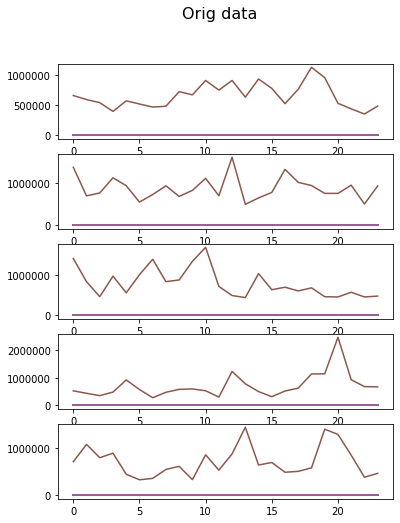

In [18]:
np.random.seed(0)
selected = 'stocks2'
perc = 10

loaded = np.load(f'{output_dir}{selected}_subsampled_train_perc_{perc}.npz')
data = loaded['data']
# print(data.shape)

# print("data mean : ", data.mean(axis=0).mean(axis=0)) 

utils.plot_samples(data, n=5, title='Orig data')